# Setup Notebook

* **Colab Users:** Setup data location in your drive accordingly.
* **Local Setup**: Put the notebook into a folder with csv files and bypass the first cell.

In [ ]:
## NOTE: 'Colab Users' only

# import drive 
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# move files to current folder
!mv 'drive/My Drive/IE582Fall2019_data_files/' .

# unzip all of the files
!unzip 'IE582Fall2019_data_files/bets.zip'
!unzip 'IE582Fall2019_data_files/booking.zip'
!unzip 'IE582Fall2019_data_files/goals.zip'
!unzip 'IE582Fall2019_data_files/matches.zip'
!unzip 'IE582Fall2019_data_files/stats.zip'

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [0]:
LEAGUE_ID = 148 # PREMIER LEAGUE ID

# Task #1

In [4]:
# read match csv data into pandas frame
matches = pd.read_csv('matches.csv')

# filter unfinished matches
matches = matches[matches['match_status'] == 'Finished']

# filter desired league matches
matches = matches[matches['league_id'] == LEAGUE_ID]

# select only desired score columns
matches = matches[['match_hometeam_score', 'match_awayteam_score']]

# visualize data for sanity check
matches.head()

,match_hometeam_score,match_awayteam_score
1,0.0,1.0
5,0.0,6.0
6,1.0,1.0
7,0.0,1.0
27,0.0,0.0


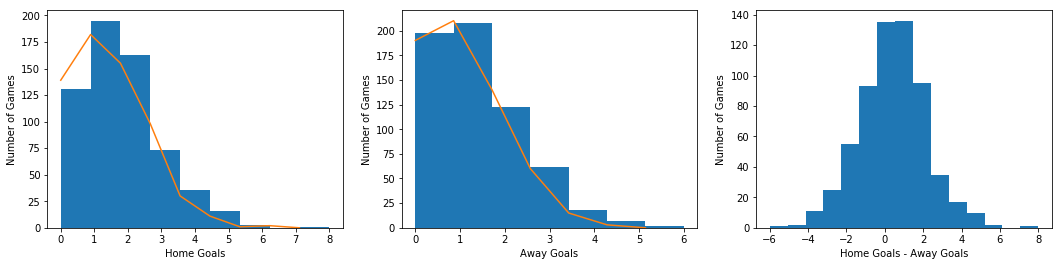

In [5]:
# create figure and axices
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 4))

# histogram & plot helper
def hist_plot(data, axis, plot_poisson=True):
    # calculate min / max of data
    data_min = data.min()
    data_max = data.max()

    # histogram data
    _, bins, _ = axis.hist(data, bins=int(data_max-data_min+1), range=(data_min, data_max))

    if plot_poisson:
        # poisson sampling
        data_mean = data.mean()
        poisson_rand = np.random.poisson(lam=data_mean, size=data.size)

        # histogram values into bins
        hist = np.histogram(poisson_rand, bins=bins)
        axis.plot(hist[1][:-1], hist[0])


# first plot
hist_plot(matches['match_hometeam_score'], axs[0])
axs[0].set_xlabel('Home Goals')
axs[0].set_ylabel('Number of Games')

# second plot
hist_plot(matches['match_awayteam_score'], axs[1])
axs[1].set_xlabel('Away Goals')
axs[1].set_ylabel('Number of Games')

# third plot
hist_plot(matches['match_hometeam_score'] - matches['match_awayteam_score'], axs[2], plot_poisson=False)
axs[2].set_xlabel('Home Goals - Away Goals')
axs[2].set_ylabel('Number of Games')

fig.show()

# Task #2

In [71]:
# prepare data by combining bets with matches information (necessary columns)
def prepare_data(league):
    # read bets csv data into pandas frame
    bets = pd.read_csv('bets.csv')
    matches = pd.read_csv('matches.csv')

    # filter unfinished matches
    matches = matches[matches['match_status'] == 'Finished']

    # filter desired league matches
    matches = matches[matches['league_id'] == league]

    # filter unrelated bets
    bets = bets[bets['variable'].isin(['odd_1', 'odd_x', 'odd_2'])]

    # append league ids and scores to data
    return pd.merge(bets, matches[['match_id', 'match_hometeam_score', 'match_awayteam_score']], on='match_id')

# get merged bets data
bets = prepare_data(LEAGUE_ID)

# visualize data for sanity check
bets.head()

,match_id,odd_bookmakers,odd_epoch,variable,value,match_hometeam_score,match_awayteam_score
0,150842,1xBet,1486711421,odd_1,5.10,0.0,0.0
1,150842,Marathonbet,1486711421,odd_1,5.20,0.0,0.0
2,150842,1xBet,1486711421,odd_x,3.70,0.0,0.0
3,150842,Marathonbet,1486711421,odd_x,3.70,0.0,0.0
4,150842,1xBet,1486711421,odd_2,1.77,0.0,0.0


In [72]:
# how many bookmaker we want to deal with
BOOKMAKER_COUNT = 4
NUMBER_OF_ODDS = 1000

# sample desired number of bookmakers
def sample_bookmakers(bets, count, min_odds):
    # sample bets randomly
    bookmakers = bets.sample(frac=1)

    # group bookmakers
    bookmakers = bookmakers.groupby('odd_bookmakers')

    # drop bookmakers with small number of entries
    bookmakers = bookmakers.filter(lambda group: group.shape[0] > min_odds)

    # drop duplicates
    bookmakers = bookmakers.drop_duplicates(subset='odd_bookmakers')

    # extract values
    bookmakers = bookmakers[:count]['odd_bookmakers'].values

    return bookmakers

# sample bookmakers
bookmakers = sample_bookmakers(bets, BOOKMAKER_COUNT, NUMBER_OF_ODDS)

# print bookmakers
print(bookmakers)

# filter bookmakers
bets = bets[bets['odd_bookmakers'].isin(bookmakers)]

# visualize data for sanity check
bets.head()

['Expekt' '10Bet' 'Marathonbet' 'Unibet']


,match_id,odd_bookmakers,odd_epoch,variable,value,match_hometeam_score,match_awayteam_score
1,150842,Marathonbet,1486711421,odd_1,5.20,0.0,0.0
3,150842,Marathonbet,1486711421,odd_x,3.70,0.0,0.0
5,150842,Marathonbet,1486711421,odd_2,1.75,0.0,0.0
8,150844,Marathonbet,1486711426,odd_1,3.10,3.0,1.0
11,150844,Marathonbet,1486711426,odd_x,3.30,3.0,1.0


In [0]:
# calculates probabilities needed (Task #2.1, #2.2)
def calc_prob(bets):
    # caclulate naive probabilities
    bets['value_reciprocal'] = 1 / bets['value']

    # calculate adjusted probabilities
    def adjust_group(group):
        tot = group['value_reciprocal'].sum()
        group['value_reciprocal_adjusted'] = group['value_reciprocal'] / tot
        return group

    # seperate data into groups on match, bookmaker and epoch
    groups = bets.groupby(['match_id', 'odd_bookmakers', 'odd_epoch'])

    # add adjusted reciprocals to groups
    groups = groups.apply(lambda group: adjust_group(group))

    # add new column to original data
    bets['value_reciprocal_adjusted'] = groups.transform('value_reciprocal_adjusted').values

    # visualize data for sanity check
    bets.head()

calc_prob(bets)

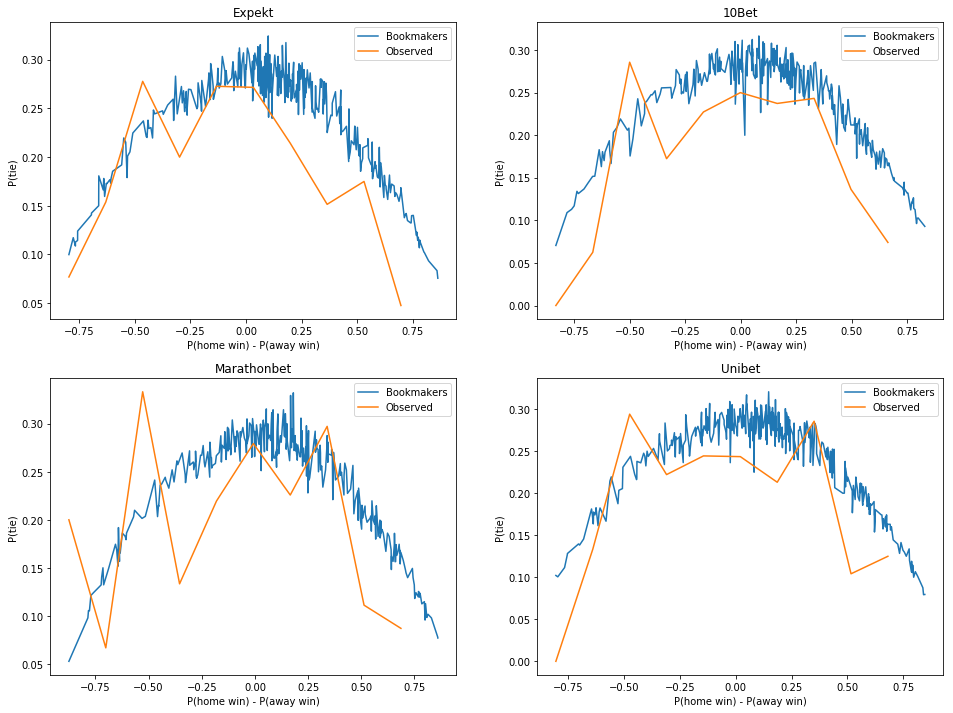

In [74]:
# create figure and axices
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# plot helper
def plot_prob(bookmaker, axis, bins=10):
    # set labels and legend
    axis.set_title(bookmaker)
    axis.set_xlabel('P(home win) - P(away win)')
    axis.set_ylabel('P(tie)')
    axis.legend(['Bookmaker', 'Observed'])

    # extract bookmaker data
    data = bets[bets['odd_bookmakers'] == bookmaker]

    # group odds by match and epoch
    odds = data.groupby(['match_id', 'odd_epoch'])
    
    # extract only related columns
    odds = odds[['variable', 'value_reciprocal_adjusted', 'match_hometeam_score', 'match_awayteam_score']]

    # initialize empty arrays to store probabilities
    home_probs, away_probs, tie_probs, tie_observed = [], [], [], []

    # extract probabilities from a group
    def extract_probs(group):
        # extract value with given condition on variable
        def extract_variable(var='variable', cond='odd_1', val='value_reciprocal_adjusted'):
            return group[group[var] == cond][val].values[0]

        # extract probabilities
        home_probs.append(extract_variable(cond='odd_1'))
        away_probs.append(extract_variable(cond='odd_2'))
        tie_probs.append(extract_variable(cond='odd_x'))

        # extract whether match ended up as tie
        tie_observed.append((group['match_hometeam_score'] == group['match_awayteam_score']).values[0])

    # extract all probabilities
    odds.apply(lambda group: extract_probs(group))

    # convert probs into numpy arrays
    home_probs = np.asarray(home_probs)
    away_probs = np.asarray(away_probs)
    tie_probs = np.asarray(tie_probs)
    tie_observed = np.asarray(tie_observed)

    # calculate difference
    diff_probs = home_probs - away_probs

    # sort probs accordingly
    sort_indices = np.argsort(diff_probs)
    diff_probs = diff_probs[sort_indices]
    tie_probs = tie_probs[sort_indices]
    tie_observed = tie_observed[sort_indices]

    # plot bookmaker probabilities
    axis.plot(diff_probs, tie_probs)

    # bin P(home win) - P(away win)
    _, bins = np.histogram(diff_probs, bins=bins)

    # bin P(observed tie)
    observed_probs = []
    index, correct = 0, 0
    for i in range(1, len(bins)):
        correct = 0 # set correct prediction count
        j = index # set iterator to current index
        while diff_probs[j] < bins[i]: # iterate to the end of the bin
            j = j + 1 # increase data points
            correct = correct + int(tie_observed[j]) # count correct predictions

        if j == index: # continue if bin is empty
            observed_probs.append(0)
            continue

        observed_probs.append(correct * 1.0 / (j - index)) # save observed probability
        index = j # save index to next bin location

    # plot observed probabilities
    axis.plot(bins[:-1], observed_probs)

    # set legend
    axis.legend(['Bookmakers', 'Observed'])

# first plot
plot_prob(bookmakers[0], axs[0][0])

# secondary plot
plot_prob(bookmakers[1], axs[0][1])

# third plot
plot_prob(bookmakers[2], axs[1][0])

# fourth plot
plot_prob(bookmakers[3], axs[1][1])

fig.show()

We see that observed probabilities are usually below implied probabilities which means that bookmakers usually over-estimate (biased towards) draw possibility. However, we see an interesting counter-pattern on the left-hand of the graphs where observed probabilities are higher than the bookmaker prediction probabilities. This means that bookmakers commonly under-estimate (biased against) draw probabilities when a strong away team faces a weaker home team.

# Task #3

Remove matches where: 
* a goal in the last 5 minutes changed the outcome of the game
* a red card is given in first 15 minutes of the game

In [130]:
GOAL_BOUNDARY = 85
RED_CARD_BOUNDARY = 15

# get merged bets data
bets = prepare_data(LEAGUE_ID)

# filter bookmakers
bets = bets[bets['odd_bookmakers'].isin(bookmakers)]

# get booking data
bookings = pd.read_csv('booking.csv')

# filter bookings to related matches
bookings = bookings[bookings['match_id'].isin(bets['match_id'].values)]

# filter bookings in first x minutes
bookings = bookings[bookings['time'].str.slice(stop=2).astype(int) <= RED_CARD_BOUNDARY]

# filter bookings with red card
bookings = bookings[bookings['card'] == 'red card']

# filter matches with bookings
bets = bets[~bets['match_id'].isin(bookings['match_id'].values)]

# get goals data
goals = pd.read_csv('goals.csv')

# filter goals to related matches
goals = goals[goals['match_id'].isin(bets['match_id'].values)]

# filter goals in last x minutes
goals = goals[goals['time'].str.slice(stop=2).astype(int) >= GOAL_BOUNDARY]

# filter matches with last minute goal results in home win
home_wins = bets[bets['match_hometeam_score'] == bets['match_awayteam_score'] + 1]
home_wins = goals[goals['match_id'].isin(home_wins['match_id'].values) & goals['home_scorer'].notna()]
bets = bets[~bets['match_id'].isin(home_wins['match_id'].values)]

# filter matches with last minute goal results in away win
away_wins = bets[bets['match_hometeam_score'] == bets['match_awayteam_score'] - 1]
away_wins = goals[goals['match_id'].isin(away_wins['match_id'].values) & goals['away_scorer'].notna()]
bets = bets[~bets['match_id'].isin(away_wins['match_id'].values)]

# filter matches with last minute goal results in tie
ties = bets[bets['match_hometeam_score'] == bets['match_awayteam_score']]
ties = goals[goals['match_id'].isin(ties['match_id'].values)]
bets = bets[~bets['match_id'].isin(ties['match_id'].values)]

# visualize data for sanity check
bets.head()

,match_id,odd_bookmakers,odd_epoch,variable,value,match_hometeam_score,match_awayteam_score
1,150842,Marathonbet,1486711421,odd_1,5.20,0.0,0.0
3,150842,Marathonbet,1486711421,odd_x,3.70,0.0,0.0
5,150842,Marathonbet,1486711421,odd_2,1.75,0.0,0.0
8,150844,Marathonbet,1486711426,odd_1,3.10,3.0,1.0
11,150844,Marathonbet,1486711426,odd_x,3.30,3.0,1.0


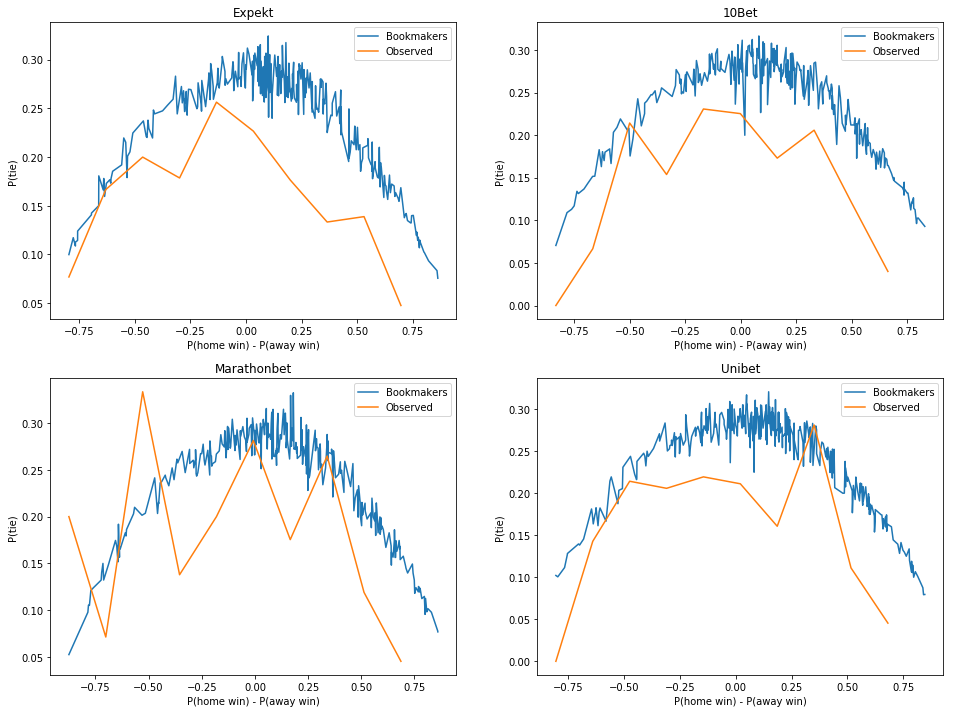

In [131]:
# calculate probabilities
calc_prob(bets)

# create figure and axices
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 12))

# first plot
plot_prob(bookmakers[0], axs[0][0])

# secondary plot
plot_prob(bookmakers[1], axs[0][1])

# third plot
plot_prob(bookmakers[2], axs[1][0])

# fourth plot
plot_prob(bookmakers[3], axs[1][1])

fig.show()

We see that observed probabilities goes even more which suggest that bookmakers are even more biased towards tie probabilities. The anamoly on the left hand side is now gone except _Marathonbet_ which suggest that bookmakers are probably underestimating the probability (or effect) of red card booking to strong away team and the possibility of last minute scores affecting the game result (again, in games where strong away team means a weaker home team).